# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import vgg16
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Model
import datetime
# from tensorflow.keras.optimizers import Adam
#perform adversiarial attacks such as Fast gradient and  ProjectedGradientDescent, DeepFool, NewtonFool
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent,NewtonFool,DeepFool
import sys

In [ ]:
# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.11.0
Keras version:2.11.0


# Task 1


## 1.1. Prepare the dataset


In [ ]:
# Uncompress the Imagenette dataset 
# (Obviously, replace the path to the folder on Google drive where you saved the dataset)
tar = tarfile.open('/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/imagenette2-160.tgz', 'r:gz')
extract_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data"
for item in tar:
    tar.extract(item, extract_path)

In [ ]:
# Function to load the images and the labels from the dataset
extract_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data"
def load_images_and_labels(directory):
    directory = os.path.join(extract_path, directory)
    imgs_list = []
    labels_list = []

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted 
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for subfolder_name in subfolders_list:
            sub_dir_path = directory + '/' + subfolder_name
            if subfolder_name != '.DS_Store':

                # Read the images as numpy arrays
                imagesList = listdir(sub_dir_path)
                for i in range(len(imagesList)):
                  tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
                  # Resize all images to 128 x 128 pixels
                  resized_img = cv2.resize(tmp_img, (128, 128)) 
                  img_arr = np.array(resized_img)
                  imgs_list.append(img_arr/255.)
                  labels_list.append(lab)
                lab += 1
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)

    return imgs, labels

# Use the above function to load the training and test datasets
train_images, train_labels = load_images_and_labels('imagenette2-160/train')
test_and_val_images, test_and_val_labels = load_images_and_labels('imagenette2-160/val')

In [ ]:
# save the extracted datasets as nparray
np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/"
np.save(np_data_path + "train_images", train_images)
np.save(np_data_path + "train_labels", train_labels)
np.save(np_data_path + "test_and_val_images", test_and_val_images)
np.save(np_data_path + "test_and_val_labels", test_and_val_labels)

In [ ]:
np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/"
train_images = np.load(np_data_path + "train_images.npy")
train_labels = np.load(np_data_path + "train_labels.npy")
test_and_val_images = np.load(np_data_path + "test_and_val_images.npy")
test_and_val_labels = np.load(np_data_path + "test_and_val_labels.npy")

# Split into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=123)
train_labels_onehot = keras.utils.to_categorical(train_labels, 10)
test_labels_onehot = keras.utils.to_categorical(test_labels, 10)
val_labels_onehot = keras.utils.to_categorical(val_labels, 10)

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (9469, 128, 128, 3) - Labels train shape: (9469,)
Images validation shape: (1570, 128, 128, 3) - Labels validation shape: (1570,)
Images test shape: (2355, 128, 128, 3) - Labels test shape: (2355,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4496687819589056
Data type float64


In [ ]:
# Function to load the images and the labels from the dataset

def get_label_dict(directory):
    lbl_dict = dict(
        n01440764='tench',
        n02102040='English springer',
        n02979186='cassette player',
        n03000684='chain saw',
        n03028079='church',
        n03394916='French horn',
        n03417042='garbage truck',
        n03425413='gas pump',
        n03445777='golf ball',
        n03888257='parachute'
    )
    directory = os.path.join(extract_path, directory)
    label_dict = {}

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted 
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for index, subfolder_name in enumerate(subfolders_list):
        if subfolder_name == '.DS_Store':
            continue
        label_dict[index - 1] = lbl_dict[subfolder_name]
    return label_dict

label_dir_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/imagenette2-160/train/"

label_dict = get_label_dict(label_dir_path)
print(label_dict)

{0: 'tench', 1: 'English springer', 2: 'cassette player', 3: 'chain saw', 4: 'church', 5: 'French horn', 6: 'garbage truck', 7: 'gas pump', 8: 'golf ball', 9: 'parachute'}


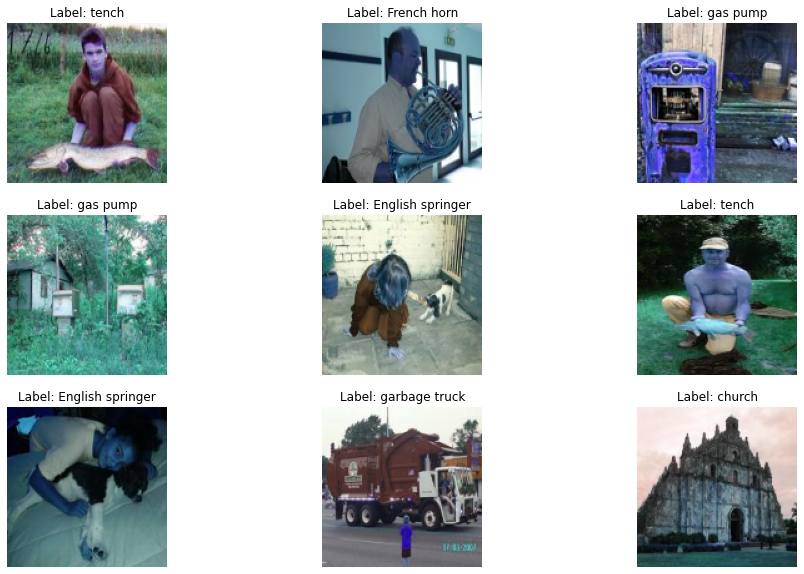

In [ ]:
# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label: ' + str(label_dict[train_labels[i[0]]]))
    plt.axis('off')

<a name = "build-train-the-model"></a>
## 1.2. Build and train the model

In [ ]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(10, activation='softmax')(x)

# The model we will train
nette_vgg16 = Model(inputs=base_model.input, outputs=predictions)
nette_vgg16.compile(#optimizer=Adam(learning_rate=1e-5),
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
#from LRFinder.keras_callback import LRFinder

#lr_finder = LRFinder(min_lr=1e-8, max_lr=1e-5)
PATIENCE = 10
callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
             #LRFinder(min_lr=1e-6, max_lr=1e-3)
            ]

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
train_model = nette_vgg16
history = train_model.fit(x= train_images,
    y= train_labels_onehot,
    batch_size=64,
    epochs=50,
    # monitoring validation loss and metrics
    validation_data=(val_images, val_labels_onehot),
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
148/148 [==============================] - 61s 319ms/step - loss: 1.4122 - accuracy: 0.5100 - val_loss: 0.6124 - val_accuracy: 0.8121 - lr: 1.0000e-05
Epoch 2/50
148/148 [==============================] - 41s 276ms/step - loss: 0.5818 - accuracy: 0.8192 - val_loss: 0.4166 - val_accuracy: 0.8732 - lr: 1.0000e-05
Epoch 3/50
148/148 [==============================] - 41s 275ms/step - loss: 0.4164 - accuracy: 0.8739 - val_loss: 0.3570 - val_accuracy: 0.8949 - lr: 1.0000e-05
Epoch 4/50
148/148 [==============================] - 41s 275ms/step - loss: 0.3260 - accuracy: 0.8997 - val_loss: 0.3309 - val_accuracy: 0.8975 - lr: 1.0000e-05
Epoch 5/50
148/148 [==============================] - 41s 276ms/step - loss: 0.2675 - accuracy: 0.9169 - val_loss: 0.3301 - val_accuracy: 0.9019 - lr: 1.0000e-05
Epoch 6/50
148/148 [==============================] - 41s 275ms/step - loss: 0.2171 - accuracy: 0.9314 - val_loss: 0.3107 - val_accuracy: 0.9057 - lr: 1.0000e-05
Epoch 7/50
148/148 [========

## 1.3. Results

In [ ]:
PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/"
MODEL_DIR = "model/"
model_name = "Trans_VGG16.h5"
working_path = os.path.join(PROJECT_ROOT_DIR, MODEL_DIR, model_name)
print(working_path)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/model/Trans_VGG16.h5


In [ ]:
#save the model
train_model.save(working_path)

#save our history so we dont lose it.
np.save(PROJECT_ROOT_DIR + MODEL_DIR + "Trans_VGG16HistoryDict.npy", history.history)

In [ ]:
#load our already trained model
loaded_model = load_model(working_path)

In [ ]:
# Evaluate on train,validation,test images
t = datetime.datetime.now()
evals_test = loaded_model.evaluate(test_images, test_labels_onehot)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(val_images, val_labels_onehot)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = loaded_model.evaluate(train_images, train_labels_onehot)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))

74/74 [==============================] - 6s 55ms/step - loss: 0.2580 - accuracy: 0.9185
Classification Accuracy Test:  0.9184713363647461
Inference time: 0:00:07.037876 

50/50 [==============================] - 3s 52ms/step - loss: 0.2609 - accuracy: 0.9197
Classification Accuracy Validation:  0.9197452068328857
Inference time: 0:00:05.566851 

296/296 [==============================] - 13s 45ms/step - loss: 0.0862 - accuracy: 0.9768
Classification Accuracy Train:  0.9767662882804871
Inference time: 0:00:25.183796


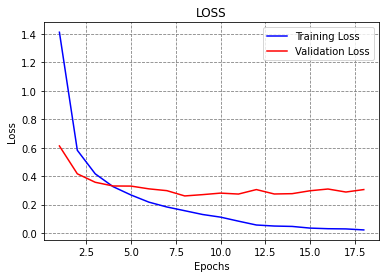

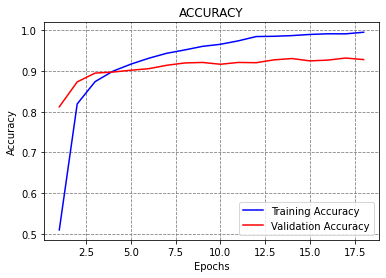

In [ ]:
history = np.load(PROJECT_ROOT_DIR + MODEL_DIR + "Trans_VGG16HistoryDict.npy",allow_pickle=True).item()
PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/"
figure_dir = "figure/"

# Plot the loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

fig_name1 = "task1_loss.png"
fig_saving_path = os.path.join(PROJECT_ROOT_DIR, figure_dir)
if not os.path.exists(fig_saving_path):
   os.makedirs(fig_saving_path)

plt.savefig(os.path.join(fig_saving_path, fig_name1))

axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

fig_name2 = "task1_accuracy.png"
plt.savefig(os.path.join(fig_saving_path, fig_name2))

plt.show()

## Task 1 Report


### a) Training results
**Table 1.** Classification accuracy.

| **Model** | Train Set | Validation Set| Test Set |
|:---:|:---:|:---:|:---:|
| Transferred_VGG16 | $0.97677$ | $0.91975$ | $0.91847$ |

### b) Visualization for history
![loss](./figure/task1_loss.png)

Fig1a. Loss for Model: Transferred_VGG16

![accuracy](./figure/task1_accuracy.png)

Fig1b. Accuracy for Model: Transferred_VGG16

### c) Observations and issues

1. **Datasets differences**:
In my first version of task one, I was trying to train the model based on the dataset from **tensorflow.datasets**. But the validation accuracy was always sticking at around 80%, no matter what hyperparameters I aligned to the model. 
<br>
The modified hyperparameters include learning rate, adding or removing layers, the neurons in the layers, early stopping and ReduceLROnPlateau callbacks, LRFinders, dropout rates, etc. But all the strategies turned out in vain in increasing the validation accuracy.

> I managed to fix this issue by changing my dataset from **tensorflow.datasets** to the **uploaded version** from [shared folder](https://vandalsuidaho-my.sharepoint.com/personal/vakanski_uidaho_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fvakanski%5Fuidaho%5Fedu%2FDocuments%2FFiles%2FMy%20Office%20Computer%2FShared%20Files%20Folder%2FCS%20504%20AML%20Course%2FAssignments%2FAssignment%201&ga=1). 

> The *false version* of my first try can be accessed in [my first version of the assignment](https://github.com/ChuBL/CS504_AdversarialML/blob/main/assg_1/CS504_2023Spring_assg_1.ipynb). I still have no idea why the same model won't work on the first dataset.

2. **Extracting dataset**: 
In my first assignment version, I extracted the image through the function `load_images_and_labels`. But the extracted and saved data occupied more than 5 Gb of storage space. In contrast, I can confirm that the source dataset is the 160px version, according to the log. So I don't know which part did I mess up.

3. **Optimizer**:
In the section [Build and train the model](#build-train-the-model), I cannot apply the optimizer of `Adam'from `tensorflow.keras.optimizers`. It will raise the error of `AttributeError: 'Adam' object has no attribute 'get_updates". Therefore I have to switch to the `Adam` from `tf.keras.optimizers.legacy`.

# Task 2

<a name = "prepare-task2-functions"></a>
## 2.1 Prepare task2 functions

In [ ]:
class Adv_Task2:
    def __init__(self):
        self.loaded_model = self.load_the_model()
        self.imgs_adv = test_images[0:200,:,:,:].copy()
        self.labels_adv_cat = test_labels_onehot[0:200].copy()
        self.epsilon_list = [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

    def fgsm_attack(self, Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
        
        
        #to increase the miss identification, we make this attacked targeted againts the true labels.
        attackFgsm = FastGradientMethod(estimator=Classifier,
                                        eps=(Epsilon/255),
                                        targeted=Targeted)                                  
        
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if  Targeted == True and Labels is not None:
            return attackFgsm.generate(Imgs_Test,Labels) 
        
        #We just want to perturbe the image set without any targeting.
        elif Targeted == False:
            return attackFgsm.generate(Imgs_Test)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: fgsm_attack a set of labels that have NOT been turned into catagorical if you are doing a targeted attack")
            print("Stopping program ...")
            sys.exit()

            
    #returns the perturbed image set from  a Fast Gradient Sign Method attack and the 
    #returns just the perturbed image set
    #param1 Epsilon of the perturbation for the image. E/255
    #param2 the model you intend to attack
    #param3 image set to attack
    #param4 is this attack targeted againts the labels?

    def pgd_attack(self, Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
        
        attackPgd = ProjectedGradientDescent(estimator = Classifier,
                                            eps=(Epsilon/255),
                                            targeted=Targeted,
                                            batch_size =256)
        
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if Targeted == True and Labels is not None:
            return attackPgd.generate(Imgs_Test,Labels)
        
        #We just want to perturbe the image set without any targeting.
        elif Targeted == False:
            return attackPgd.generate(Imgs_Test)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: pgd_attack a set of labels if you are doing targeted attacks")
            print("Stopping program ...")
            sys.exit()

    def load_the_model(self):
        PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/"
        MODEL_DIR = "model/"
        model_name = "Trans_VGG16.h5"
        working_path = os.path.join(PROJECT_ROOT_DIR, MODEL_DIR, model_name)
        print(working_path)
        #load our already trained model
        loaded_model = tf.keras.models.load_model(working_path)
        return loaded_model

    def train_model(self):
        #List for plotting and storing images to display. 
        fgsm_acc_list = []
        fgsm_image_list =[]
        fgsm_pred_list =[]
        fgsm_pertb_list =[]
        fgsm_image_whole_list = []

        pgd_acc_list = []
        pgd_image_list = []
        pgd_pred_list = []
        pgd_pertb_list = []
        pgd_image_whole_list = []

        epsilon_list = self.epsilon_list

        classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 1))

        # self.imgs_adv = test_images[0:200,:,:,:].copy()
        # self.labels_adv_cat = test_labels_onehot[0:200].copy()

        for eps in epsilon_list:
            
            imgs_adv_fgsm = self.fgsm_attack(eps*255,classifier,self.imgs_adv,Targeted=False,Labels=self.labels_adv_cat)
            imgs_adv_pgd = self.pgd_attack(eps*255,classifier,self.imgs_adv,Targeted=False,Labels=self.labels_adv_cat)
            
            # fgsm_image_list.append(imgs_adv_fgsm[0])
            # pgd_image_list.append(imgs_adv_pgd[0])
            
            fgsm_image_whole_list.append(imgs_adv_fgsm)
            pgd_image_whole_list.append(imgs_adv_pgd)
            
            loss_test_fgsm, accuracy_test_fgsm = loaded_model.evaluate(imgs_adv_fgsm, self.labels_adv_cat)
            loss_test_pgd, accuracy_test_pgd = loaded_model.evaluate(imgs_adv_pgd, self.labels_adv_cat)
            
            fgsm_acc_list.append(accuracy_test_fgsm)
            pgd_acc_list.append(accuracy_test_pgd)
            
            #predict first image
            prediction_fgsm = loaded_model.predict(imgs_adv_fgsm[0:1,:,:,:])
            prediction_pgd = loaded_model.predict(imgs_adv_pgd[0:1,:,:,:])
            
            fgsm_pred_list.append(prediction_fgsm.argmax(axis=-1))
            pgd_pred_list.append(prediction_pgd.argmax(axis=-1))

        # self.save_npy(fgsm_image_list, "fgsm_image_list")
        # self.save_npy(pgd_image_list, "pgd_image_list")
        self.save_npy(fgsm_image_whole_list, "fgsm_image_whole_list")
        self.save_npy(pgd_image_whole_list, "pgd_image_whole_list")
        self.save_npy(fgsm_acc_list, "fgsm_acc_list")
        self.save_npy(pgd_acc_list, "pgd_acc_list")
        self.save_npy(fgsm_pred_list, "fgsm_pred_list")
        self.save_npy(pgd_pred_list, "pgd_pred_list")


        
    def save_npy(self, NPY, FILENAME):
        NPY = np.asarray(NPY)
        # save the datasets as nparray
        np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/task2/"
        np.save(np_data_path + FILENAME, NPY)

    def load_saved_npy(self):
        np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/task2/"
        # self.fgsm_image_list = np.load(np_data_path + "fgsm_image_list.npy")
        # self.pgd_image_list = np.load(np_data_path + "pgd_image_list.npy")
        self.fgsm_image_whole_list = np.load(np_data_path + "fgsm_image_whole_list.npy")
        self.pgd_image_whole_list = np.load(np_data_path + "pgd_image_whole_list.npy")
        self.fgsm_acc_list = np.load(np_data_path + "fgsm_acc_list.npy")
        self.pgd_acc_list = np.load(np_data_path + "pgd_acc_list.npy")
        self.fgsm_pred_list = np.load(np_data_path + "fgsm_pred_list.npy")
        self.pgd_pred_list = np.load(np_data_path + "pgd_pred_list.npy")



## 2.2 Train the model

In [ ]:
np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/"
test_and_val_images = np.load(np_data_path + "test_and_val_images.npy")
test_and_val_labels = np.load(np_data_path + "test_and_val_labels.npy")
# Split into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=123)
test_labels_onehot = keras.utils.to_categorical(test_labels, 10)

In [ ]:
at2 = Adv_Task2()

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/model/Trans_VGG16.h5


In [ ]:
at2.train_model()

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

## 2.3 Results

In [ ]:
at2 = Adv_Task2()
at2.load_saved_npy()

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/model/Trans_VGG16.h5


In [ ]:
def print_classification_acc(Classifier, nameOfDataSet,imgs,labels):
        x_test_robust_pred = np.argmax(Classifier.predict(imgs), axis=1)
        nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(labels, axis=1))


        print(nameOfDataSet + " Classification")
        print("Correctly Classified: {}".format(nb_correct_robust_pred))
        print("Incorrectly Classified: {}".format(len(imgs) -nb_correct_robust_pred))
        print("Percent Correct Classified: {}%\n".format((nb_correct_robust_pred/len(imgs)) *100))

def print_all_acc(AT):
    #Clean testing images
    print_classification_acc(AT.loaded_model,"Clean Testing Set", AT.imgs_adv, AT.labels_adv_cat)

    eps_list = [1/255, 5/255, 8/255]
    for e in eps_list:
        if e in AT.epsilon_list:
            index = AT.epsilon_list.index(e)
            #FGSM attacked images
            fgsm_dataset = "FGSM Testing Set 𝜖 = " + str(round(e, 4))
            print_classification_acc(AT.loaded_model,fgsm_dataset,AT.fgsm_image_whole_list[index], AT.labels_adv_cat)
            #PGD attacked images
            pgd_dataset = "PGD Testing Set 𝜖 = " + str(round(e, 4))
            print_classification_acc(AT.loaded_model,pgd_dataset,AT.pgd_image_whole_list[index], AT.labels_adv_cat)

print_all_acc(at2)

Clean Testing Set Classification
Correctly Classified: 186
Incorrectly Classified: 14
Percent Correct Classified: 93.0%

FGSM Testing Set 𝜖 = 0.0039 Classification
Correctly Classified: 165
Incorrectly Classified: 35
Percent Correct Classified: 82.5%

PGD Testing Set 𝜖 = 0.0039 Classification
Correctly Classified: 161
Incorrectly Classified: 39
Percent Correct Classified: 80.5%

FGSM Testing Set 𝜖 = 0.0196 Classification
Correctly Classified: 63
Incorrectly Classified: 137
Percent Correct Classified: 31.5%

PGD Testing Set 𝜖 = 0.0196 Classification
Correctly Classified: 49
Incorrectly Classified: 151
Percent Correct Classified: 24.5%

FGSM Testing Set 𝜖 = 0.0314 Classification
Correctly Classified: 42
Incorrectly Classified: 158
Percent Correct Classified: 21.0%

PGD Testing Set 𝜖 = 0.0314 Classification
Correctly Classified: 36
Incorrectly Classified: 164
Percent Correct Classified: 18.0%



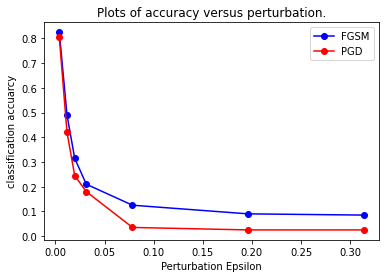

In [ ]:
def plot_lines(AT):
    plt.plot(AT.epsilon_list, AT.fgsm_acc_list, 'b', label='FGSM',marker='o')
    plt.plot(AT.epsilon_list, AT.pgd_acc_list, 'r', label='PGD',marker='o')

    plt.legend()
    plt.title('Accuracy vs Perturbation')
    plt.xlabel('Perturbation Epsilon')
    plt.ylabel('classification accuarcy')
    plt.title('Plots of accuracy versus perturbation.')
    plt.savefig("/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/figure/task2_acc.png")

    plt.show()

plot_lines(at2)

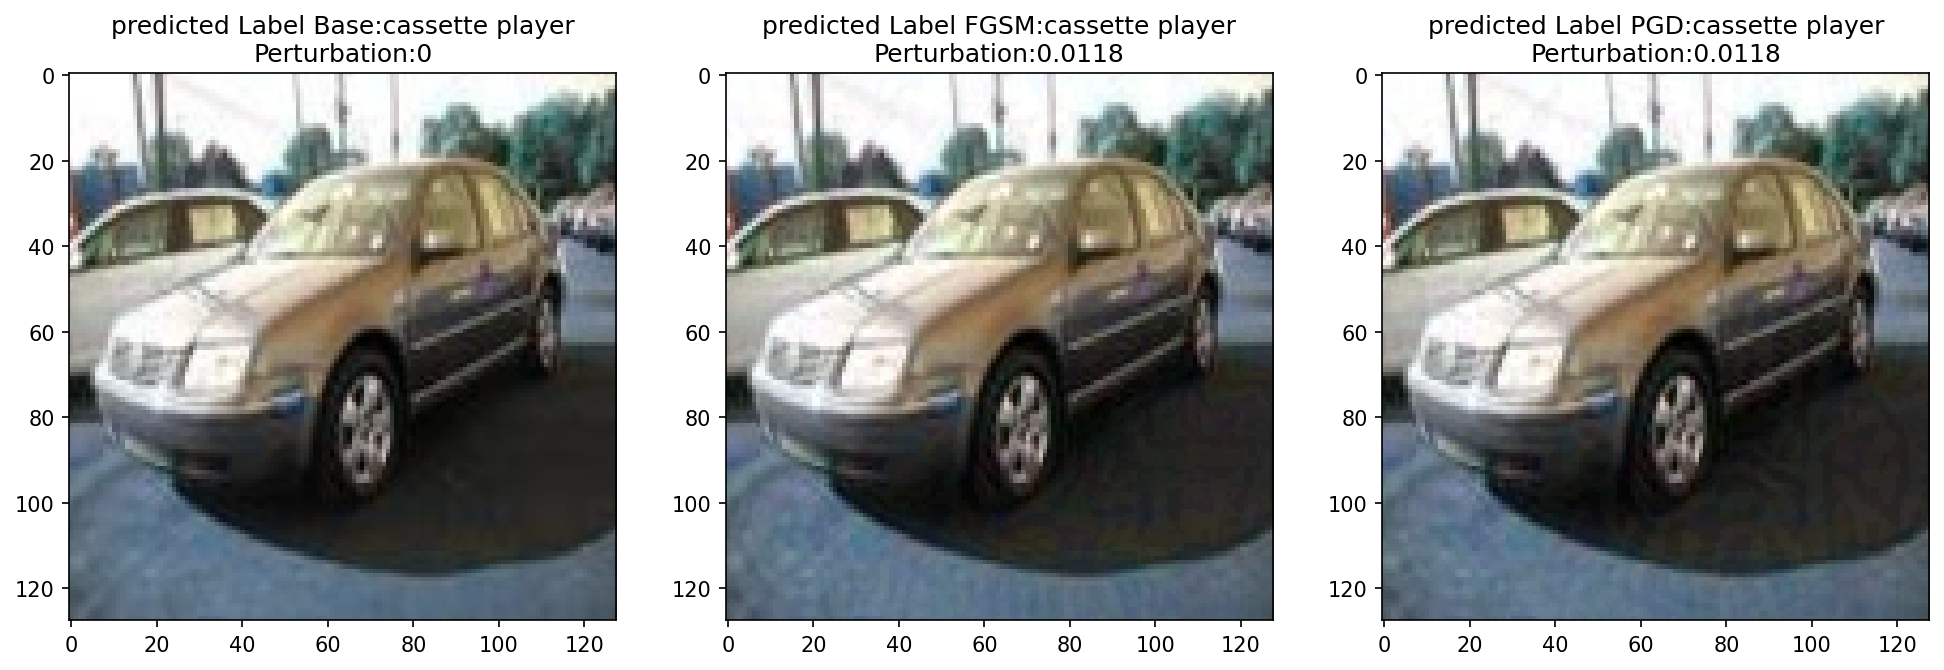

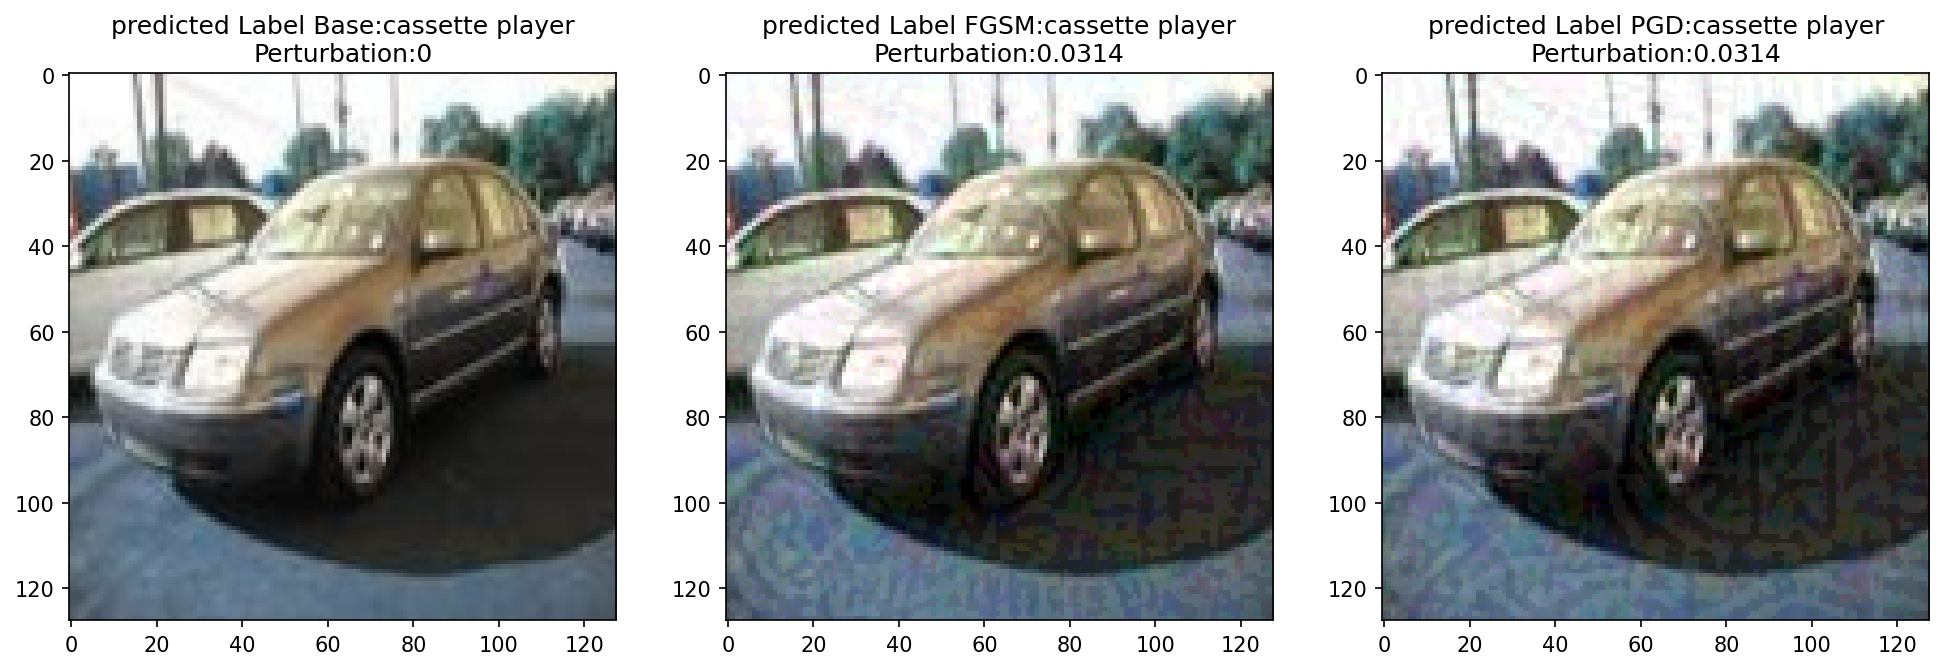

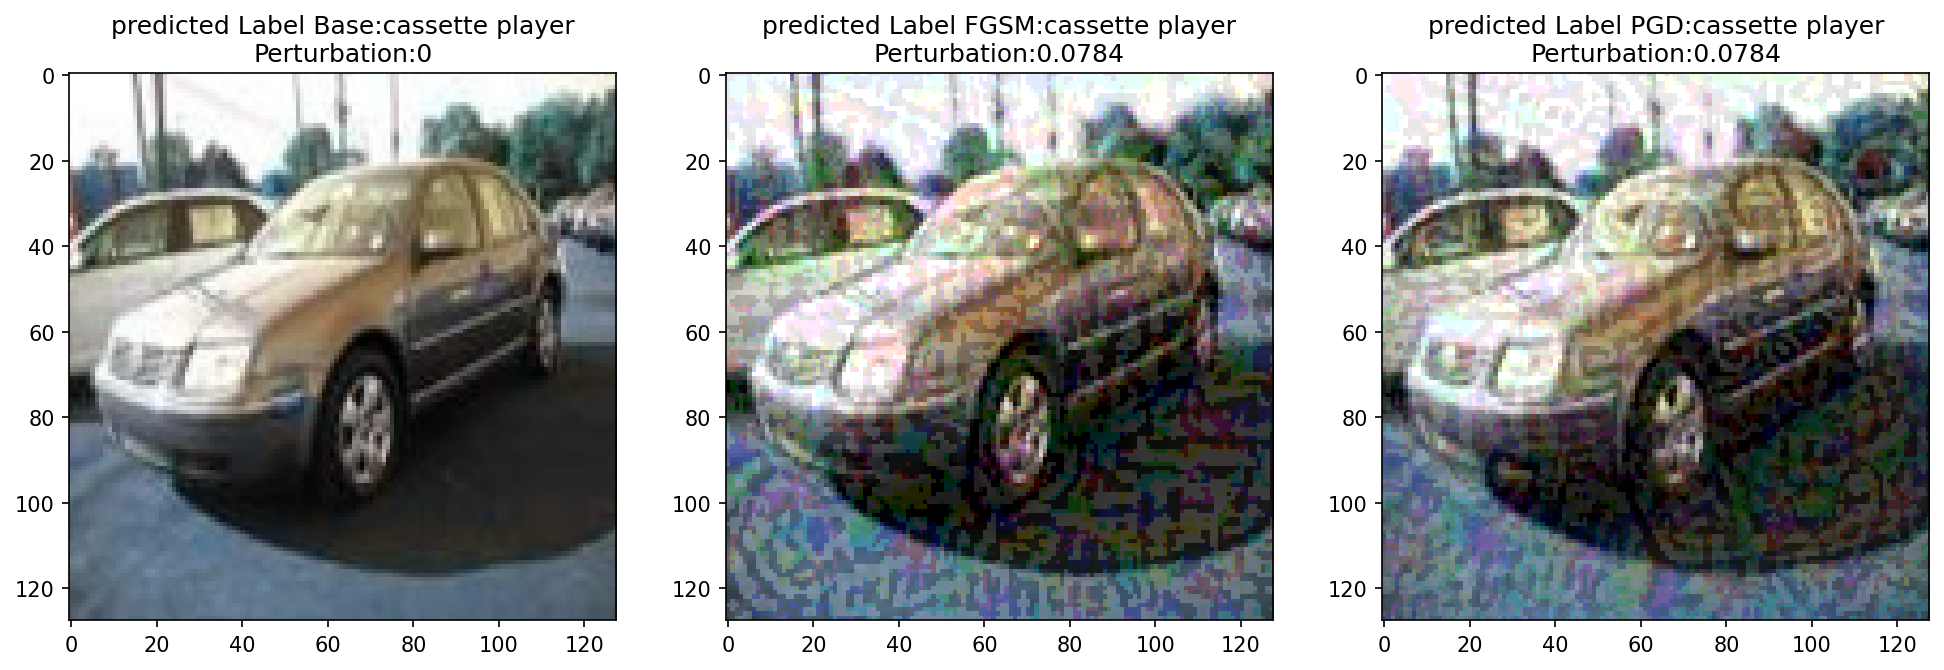

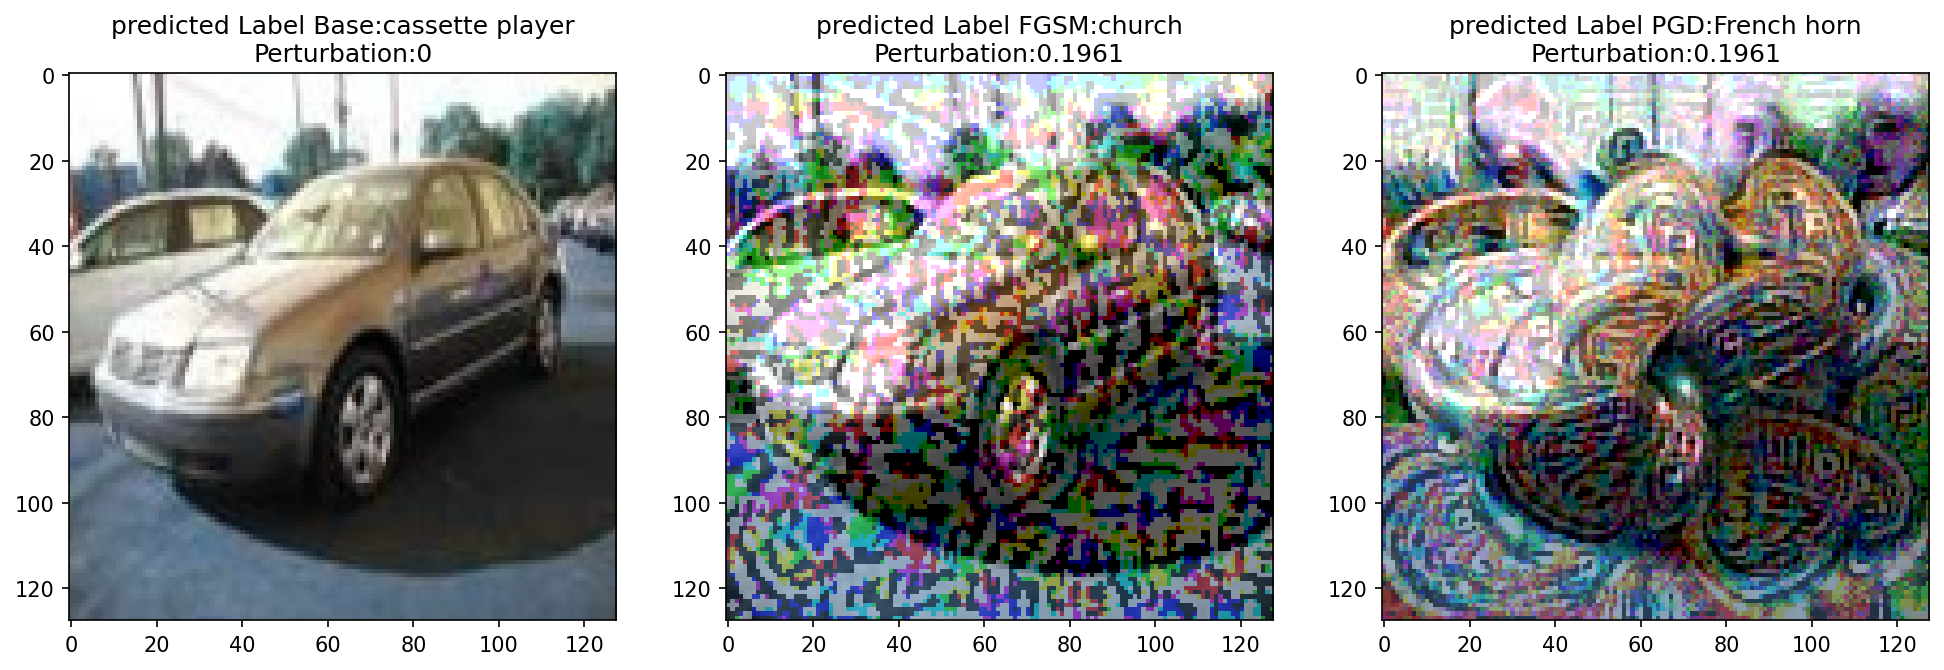

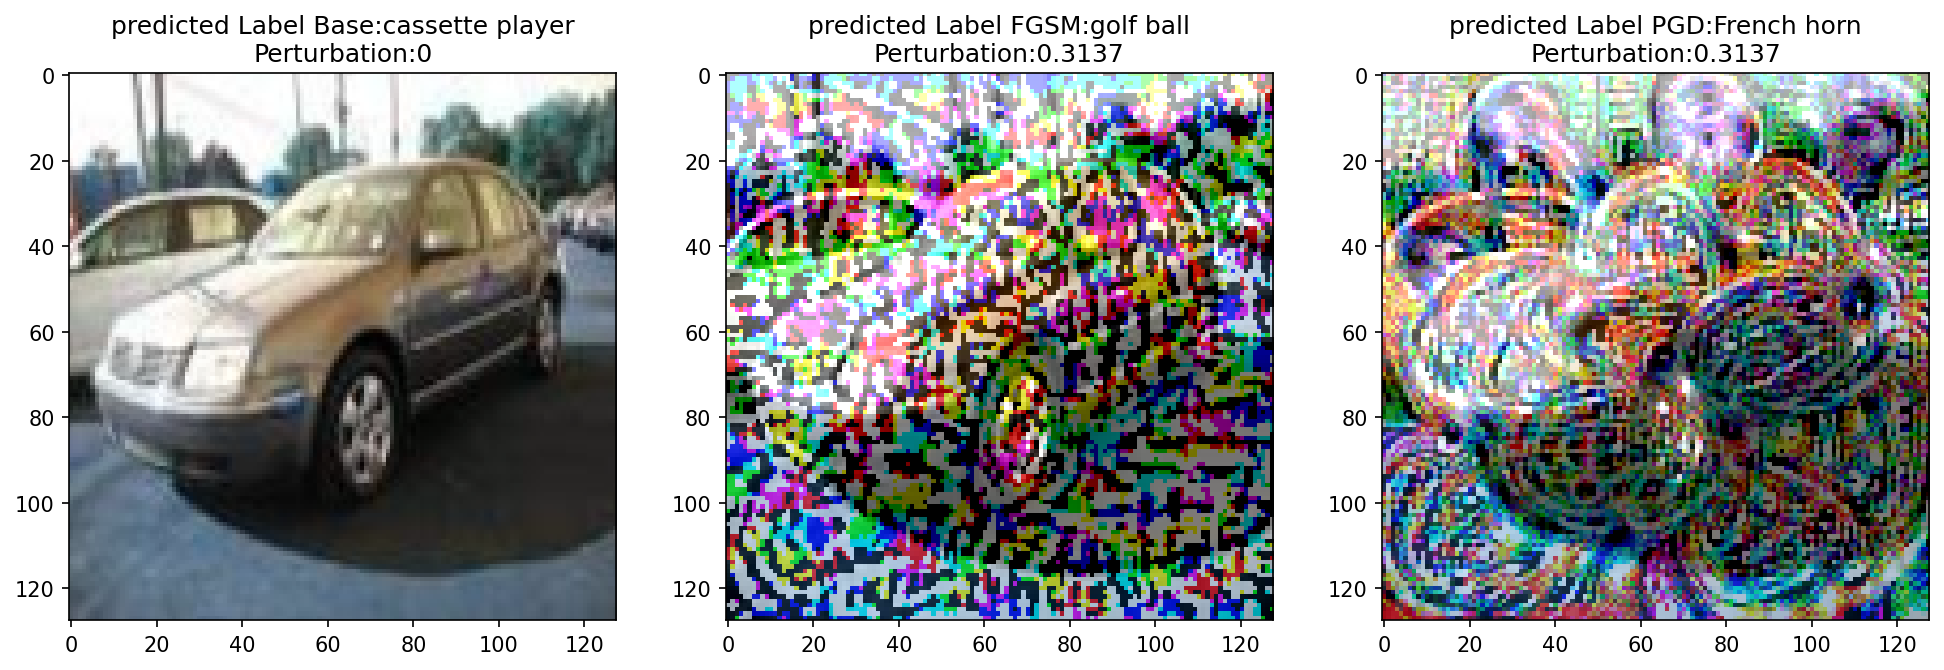

In [ ]:
def show_images(EpsilonIndex, AT):
    plt.figure(figsize=(16, 16), dpi=150)
    
    plt.subplot(2,3,1)
    plt.title('predicted Label Base:' + str(label_dict[np.argmax(AT.labels_adv_cat[0])])+ '\n' + 'Perturbation:' + str(0))
    plt.imshow(AT.imgs_adv[0])

    plt.subplot(2,3,2)
    plt.title('predicted Label FGSM:' + str(label_dict[int(AT.fgsm_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(AT.epsilon_list[EpsilonIndex],4)))
    plt.imshow(AT.fgsm_image_whole_list[EpsilonIndex][0])

    plt.subplot(2,3,3)
    plt.title('predicted Label PGD:' + str(label_dict[int(AT.pgd_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(AT.epsilon_list[EpsilonIndex],4)))
    plt.imshow(AT.pgd_image_whole_list[EpsilonIndex][0])
    fig_filename = "task2_c" + str(EpsilonIndex) + ".png"
    fig_path = os.path.join("/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/figure/", fig_filename)
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

    plt.show()

def show_all_images(AT):
    new_epsilon = [3/255, 8/255, 20/255, 50/255, 80/255]
    for item in new_epsilon:
        if item in AT.epsilon_list:
            index = AT.epsilon_list.index(item)
            show_images(index, AT)

    #plt.show()
show_all_images(at2)

## Task 2 report

### a) Classification accuracy tables
| **Model** | Clean images | Adversarial images $\epsilon = 1/255$ | Adversarial images $\epsilon = 5/255$ | Adversarial images $\epsilon = 8/255$ | 
| :---: | :---: | :---: | :---: | :---: |
| **FGSM attack** | $92.5\%$ | $81.5\%$ | $38.5\%$ | $27.0\%$ |
| **PGD attack** | $92.5\%$ | $78.5\%$  | $30.5\%$ | $17.0\%$ |

### b) Plots of accuracy versus perturbation
![Accuracy versus perturbation](./figure/task2_acc.png)

**Fig 2a.** Plots of accuracy versus perturbation

### c) Figures with added adversarial perturbation and the labels
![Accuracy versus perturbation1](./figure/task2_c1.png)

![Accuracy versus perturbation3](./figure/task2_c3.png)

![Accuracy versus perturbation4](./figure/task2_c4.png)

![Accuracy versus perturbation5](./figure/task2_c5.png)

![Accuracy versus perturbation6](./figure/task2_c6.png)

**Figure 2b.** Examples of adversarial images

### d) Analysis
**Training**: Through the training section, I noticed that most of the logs are about the PGD model training results. Thus, the training for the FGSM model took very little time to accomplish. According to the analysis in section e), PGD consumed more computation time because it has a projection to apply in each iteration. In contrast, FGSM applied the perturbation at the end of each epoch and skipped the projecting step.

**Results**: From the table in section a), we can see that as the $\epsilon$ gradually grows, the accuracy differences between FGSM and PGD get more extensive but not necessarily remarkable. The attached images in the exact value of $\epsilon$ seem hard to distinguish before $20/255$. However, before reaching this value, both results start to become weird according to human eyes. 

In this case, we found the limitation for conducting a reasonable attack without being noticed too obvious by humans is $\epsilon < 8$. And in this area, PGD outperformed FGSM in testing accuracy, but FGSM consumed much less time with a reasonable sacrifice of accuracy.

**Parameter Naming**: Because many parameters share the same definition across task 2 and task 3, I have to refactor all the functions in a class in [section 2.1](#prepare-task2-functions). Otherwise, some of my plots will get ruined.

### e) Explain the meaning of the perturbation magnitude $\epsilon=8/255$
#### FGSM
In the adversarial of FGSM, the perturbation of 
$$\eta = \epsilon\text{sign}(\triangledown_{x} J(\theta, \boldsymbol{x}, y))$$
is calculated according to the gradiant of cost function $J(\theta, \boldsymbol{x}, y)$ with respect to $x$, which is the input to the model. Note that during the backpropagation of a non-linear model like a neural network, this part of the perturbation equation is the byproduct of each training epoch. The function $\text{sign()}$ is applied to get the max norm of the gradient. The overall computation can be simplified as a linear multiply, thus making the computation of FGSM perturbation very fast.
The $\epsilon = 8/255$ here means we would apply either positive or negative perturbation of $\epsilon = 8/255$ to the pixels, according to the directions of gradients of the cost function.

#### PGD
In the adversarial of FGSM, the perturbation is applied to the data during each iteration. Given the iteration of $k$, the attacked data of
$$ x^{(k+1)} = P_S(x^{(k)} + \eta^{(K)}\triangledown f(x^{(k)}))$$
is calculated according to the product of respect cost function and $\epsilon$, then added with the data from the last iteration, and finally projected back to the space of the targets. 
Given the $\epsilon = 8/255$, the PGD will compute the cost function, amplify it with $8/255$, then add it to the input data for that iteration and project it back to $S$. The norm for the gradient isn't fixed and may vary according to the settings. If we apply $l_\infty$, we will get the same sign of the gradient as FGSM.


# Task 3

## 3.1 Prepare task3 functions

In [ ]:
class Adv_Task3:
    def __init__(self):
        self.loaded_model = self.load_the_model()
        self.epsilon_list = [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

    def load_adv_dataset(self, test_images):
        # extract church images
        imgs_church = []
        for index, label in enumerate(test_labels_onehot):
            if 4 == np.argmax(label):
                img = test_images[index].copy()
                imgs_church.append(img)
        
        self.imgs_church = np.asarray(imgs_church)
        self.labels_church_cat = np.full(shape=(len(imgs_church), 10), fill_value=keras.utils.to_categorical(np.array(4), 10))
        self.labels_gas_cat = np.full(shape=(len(imgs_church), 10), fill_value=keras.utils.to_categorical(np.array(7), 10))


    def fgsm_attack(self, Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
        
        
        #to increase the miss identification, we make this attacked targeted againts the true labels.
        attackFgsm = FastGradientMethod(estimator=Classifier,
                                        eps=(Epsilon/255),
                                        targeted=Targeted)                                  
        
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if  Targeted == True and Labels is not None:
            return attackFgsm.generate(Imgs_Test,Labels) 
        
        #We just want to perturbe the image set without any targeting.
        elif Targeted == False:
            return attackFgsm.generate(Imgs_Test)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: fgsm_attack a set of labels that have NOT been turned into catagorical if you are doing a targeted attack")
            print("Stopping program ...")
            sys.exit()

            
    #returns the perturbed image set from  a Fast Gradient Sign Method attack and the 
    #returns just the perturbed image set
    #param1 Epsilon of the perturbation for the image. E/255
    #param2 the model you intend to attack
    #param3 image set to attack
    #param4 is this attack targeted againts the labels?

    def pgd_attack(self, Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
        
        attackPgd = ProjectedGradientDescent(estimator = Classifier,
                                            eps=(Epsilon/255),
                                            targeted=Targeted,
                                            batch_size =256)
        
        #check our parameters and perform the proper actions
        #if we have labels and we are targeted we can generate the proper images
        if Targeted == True and Labels is not None:
            return attackPgd.generate(Imgs_Test,Labels)
        
        #We just want to perturbe the image set without any targeting.
        elif Targeted == False:
            return attackPgd.generate(Imgs_Test)
        
        #some form of parameter error
        else:
            print("make sure you have given the function: pgd_attack a set of labels if you are doing targeted attacks")
            print("Stopping program ...")
            sys.exit()

    def load_the_model(self):
        PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/"
        MODEL_DIR = "model/"
        model_name = "Trans_VGG16.h5"
        working_path = os.path.join(PROJECT_ROOT_DIR, MODEL_DIR, model_name)
        print(working_path)
        #load our already trained model
        loaded_model = tf.keras.models.load_model(working_path)
        return loaded_model

    def train_model(self):
        #List for plotting and storing images to display. 
        fgsm_gas_acc_list = []
        fgsm_chr_acc_list = []
        fgsm_image_list =[]
        fgsm_pred_list =[]
        fgsm_pertb_list =[]
        fgsm_image_whole_list = []

        pgd_gas_acc_list = []
        pgd_chr_acc_list = []
        pgd_image_list = []
        pgd_pred_list = []
        pgd_pertb_list = []
        pgd_image_whole_list = []

        epsilon_list = self.epsilon_list

        classifier = KerasClassifier(model=self.loaded_model, clip_values=(0, 1))

        for eps in epsilon_list:
            
            imgs_adv_fgsm = self.fgsm_attack(eps*255,classifier,self.imgs_church,Targeted=True,Labels=self.labels_gas_cat)
            imgs_adv_pgd = self.pgd_attack(eps*255,classifier,self.imgs_church,Targeted=True,Labels=self.labels_gas_cat)
            
            #fgsm_image_list.append(imgs_adv_fgsm[0])
            #pgd_image_list.append(imgs_adv_pgd[0])

            fgsm_image_whole_list.append(imgs_adv_fgsm)
            pgd_image_whole_list.append(imgs_adv_pgd)


            loss_gas_fgsm, accuracy_gas_fgsm = loaded_model.evaluate(imgs_adv_fgsm, self.labels_gas_cat)
            loss_chr_fgsm, accuracy_chr_fgsm = loaded_model.evaluate(imgs_adv_fgsm, self.labels_church_cat)
            loss_gas_pgd, accuracy_gas_pgd = loaded_model.evaluate(imgs_adv_pgd, self.labels_gas_cat)
            loss_chr_pgd, accuracy_chr_pgd = loaded_model.evaluate(imgs_adv_pgd, self.labels_church_cat)
            
            fgsm_gas_acc_list.append(accuracy_gas_fgsm)
            fgsm_chr_acc_list.append(accuracy_chr_fgsm)
            pgd_gas_acc_list.append(accuracy_gas_pgd)
            pgd_chr_acc_list.append(accuracy_chr_pgd)

            #predict first image
            prediction_fgsm = loaded_model.predict(imgs_adv_fgsm[0:1,:,:,:])
            prediction_pgd = loaded_model.predict(imgs_adv_pgd[0:1,:,:,:])
            
            fgsm_pred_list.append(prediction_fgsm.argmax(axis=-1))
            pgd_pred_list.append(prediction_pgd.argmax(axis=-1))

        self.save_npy(fgsm_image_whole_list, "fgsm_image_whole_list")
        self.save_npy(pgd_image_whole_list, "pgd_image_whole_list")

        self.save_npy(fgsm_gas_acc_list, "fgsm_gas_acc_list")
        self.save_npy(fgsm_chr_acc_list, "fgsm_chr_acc_list")
        self.save_npy(pgd_gas_acc_list, "pgd_gas_acc_list")
        self.save_npy(pgd_chr_acc_list, "pgd_chr_acc_list")

        self.save_npy(fgsm_pred_list, "fgsm_pred_list")
        self.save_npy(pgd_pred_list, "pgd_pred_list")
        
    def save_npy(self, NPY, FILENAME):
        NPY = np.asarray(NPY)
        # save the datasets as nparray
        np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/task3/"
        np.save(np_data_path + FILENAME, NPY)

    def load_saved_npy(self):
        np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/task3/"
        # self.fgsm_image_list = np.load(np_data_path + "fgsm_image_list.npy")
        # self.pgd_image_list = np.load(np_data_path + "pgd_image_list.npy")
        self.fgsm_image_whole_list = np.load(np_data_path + "fgsm_image_whole_list.npy")
        self.pgd_image_whole_list = np.load(np_data_path + "pgd_image_whole_list.npy")

        self.fgsm_gas_acc_list = np.load(np_data_path + "fgsm_gas_acc_list.npy")
        self.fgsm_chr_acc_list = np.load(np_data_path + "fgsm_chr_acc_list.npy")
        self.pgd_gas_acc_list = np.load(np_data_path + "pgd_gas_acc_list.npy")
        self.pgd_chr_acc_list = np.load(np_data_path + "pgd_chr_acc_list.npy")

        self.fgsm_pred_list = np.load(np_data_path + "fgsm_pred_list.npy")
        self.pgd_pred_list = np.load(np_data_path + "pgd_pred_list.npy")



## 3.2 Train the model

In [ ]:
np_data_path = "/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/data/numpy/"
test_and_val_images = np.load(np_data_path + "test_and_val_images.npy")
test_and_val_labels = np.load(np_data_path + "test_and_val_labels.npy")
# Split into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=123)
test_labels_onehot = keras.utils.to_categorical(test_labels, 10)

In [ ]:
# initialize at3 with loaded model from task1
at3 = Adv_Task3()

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/model/Trans_VGG16.h5


In [ ]:
# load church images and labels
at3.load_adv_dataset(test_images)

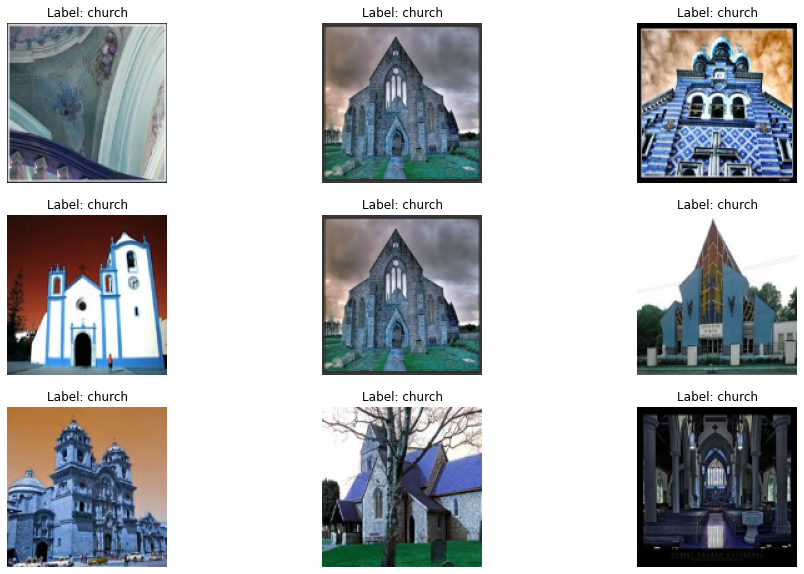

In [ ]:
def show_church(AT):
    plt.figure(figsize=(16, 10))
    for n in range(9):
        i = np.random.randint(0, len(AT.imgs_church), 1)
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(AT.imgs_church[i[0]])
        plt.title('Label: ' + str(label_dict[np.argmax(AT.labels_church_cat[i[0]])]))
        plt.axis('off')

show_church(at3)

In [ ]:
at3.train_model()

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

## 3.3 Results

In [ ]:
at3 = Adv_Task3()
at3.load_saved_npy()
at3.load_adv_dataset(test_images)

/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/model/Trans_VGG16.h5


In [ ]:
def print_classification_acc(Classifier, nameOfDataSet,imgs, AT):
        x_test_robust_pred = np.argmax(Classifier.predict(imgs), axis=1)
        church_pred_count = np.sum(x_test_robust_pred == np.argmax(AT.labels_church_cat, axis=1))
        gas_pred_count = np.sum(x_test_robust_pred == np.argmax(AT.labels_gas_cat, axis=1))


        print(nameOfDataSet + " Classification")
        print("Classified as Church: {}".format(church_pred_count))
        print("Classified as Gas Pump: {}".format(gas_pred_count))
        print("Percent Classified as Church: {}%".format((church_pred_count/len(imgs)) *100))
        print("Percent Classified as Gas Pump: {}%\n".format((gas_pred_count/len(imgs)) *100))

def print_all_acc(AT):

    eps_list = [1/255, 3/255, 8/255, 20/255, 50/255, 80/255]
    for e in eps_list:
        if e in AT.epsilon_list:
            index = AT.epsilon_list.index(e)
            #FGSM attacked images
            fgsm_dataset = "FGSM Testing Set 𝜖 = " + str(round(e, 4))
            print_classification_acc(AT.loaded_model,fgsm_dataset,AT.fgsm_image_whole_list[index], AT)
            #PGD attacked images
            pgd_dataset = "PGD Testing Set 𝜖 = " + str(round(e, 4))
            print_classification_acc(AT.loaded_model,pgd_dataset,AT.pgd_image_whole_list[index],AT)

print_all_acc(at3)

FGSM Testing Set 𝜖 = 0.0039 Classification
Classified as Church: 232
Classified as Gas Pump: 3
Percent Classified as Church: 94.3089430894309%
Percent Classified as Gas Pump: 1.2195121951219512%

PGD Testing Set 𝜖 = 0.0039 Classification
Classified as Church: 238
Classified as Gas Pump: 1
Percent Classified as Church: 96.7479674796748%
Percent Classified as Gas Pump: 0.40650406504065045%

FGSM Testing Set 𝜖 = 0.0118 Classification
Classified as Church: 161
Classified as Gas Pump: 29
Percent Classified as Church: 65.4471544715447%
Percent Classified as Gas Pump: 11.788617886178862%

PGD Testing Set 𝜖 = 0.0118 Classification
Classified as Church: 227
Classified as Gas Pump: 11
Percent Classified as Church: 92.27642276422763%
Percent Classified as Gas Pump: 4.471544715447155%

FGSM Testing Set 𝜖 = 0.0314 Classification
Classified as Church: 73
Classified as Gas Pump: 62
Percent Classified as Church: 29.67479674796748%
Percent Classified as Gas Pump: 25.203252032520325%

PGD Testing Set 𝜖 

In [ ]:
def print_accs(AT):
    epsilon_list = [1/255, 3/255, 8/255, 20/255, 50/255, 80/255]

    for e in epsilon_list:
        if e in AT.epsilon_list:
            index = AT.epsilon_list.index(e)
            print("𝜖 = {:.4f}, FGSM - Church: {:.2f}%, FGSM - Gas Pump: {:.2f}%, \
                PGD - Church: {:.2f}%, PGD - Gas Pump: {:.2f}%" \
                .format(float(e), float(AT.fgsm_chr_acc_list[index])*100, \
                        float(AT.fgsm_gas_acc_list[index])*100, \
                        float(AT.pgd_chr_acc_list[index])*100, \
                        float(AT.pgd_gas_acc_list[index])*100))
        
print_accs(at3)

𝜖 = 0.0039, FGSM - Church: 94.31%, FGSM - Gas Pump: 1.22%,                 PGD - Church: 96.75%, PGD - Gas Pump: 0.41%
𝜖 = 0.0118, FGSM - Church: 65.45%, FGSM - Gas Pump: 11.79%,                 PGD - Church: 92.28%, PGD - Gas Pump: 4.47%
𝜖 = 0.0314, FGSM - Church: 29.67%, FGSM - Gas Pump: 25.20%,                 PGD - Church: 91.87%, PGD - Gas Pump: 1.22%
𝜖 = 0.0784, FGSM - Church: 29.67%, FGSM - Gas Pump: 12.20%,                 PGD - Church: 5.69%, PGD - Gas Pump: 92.68%
𝜖 = 0.1961, FGSM - Church: 70.33%, FGSM - Gas Pump: 0.00%,                 PGD - Church: 17.07%, PGD - Gas Pump: 77.24%
𝜖 = 0.3137, FGSM - Church: 84.96%, FGSM - Gas Pump: 0.00%,                 PGD - Church: 2.03%, PGD - Gas Pump: 97.15%


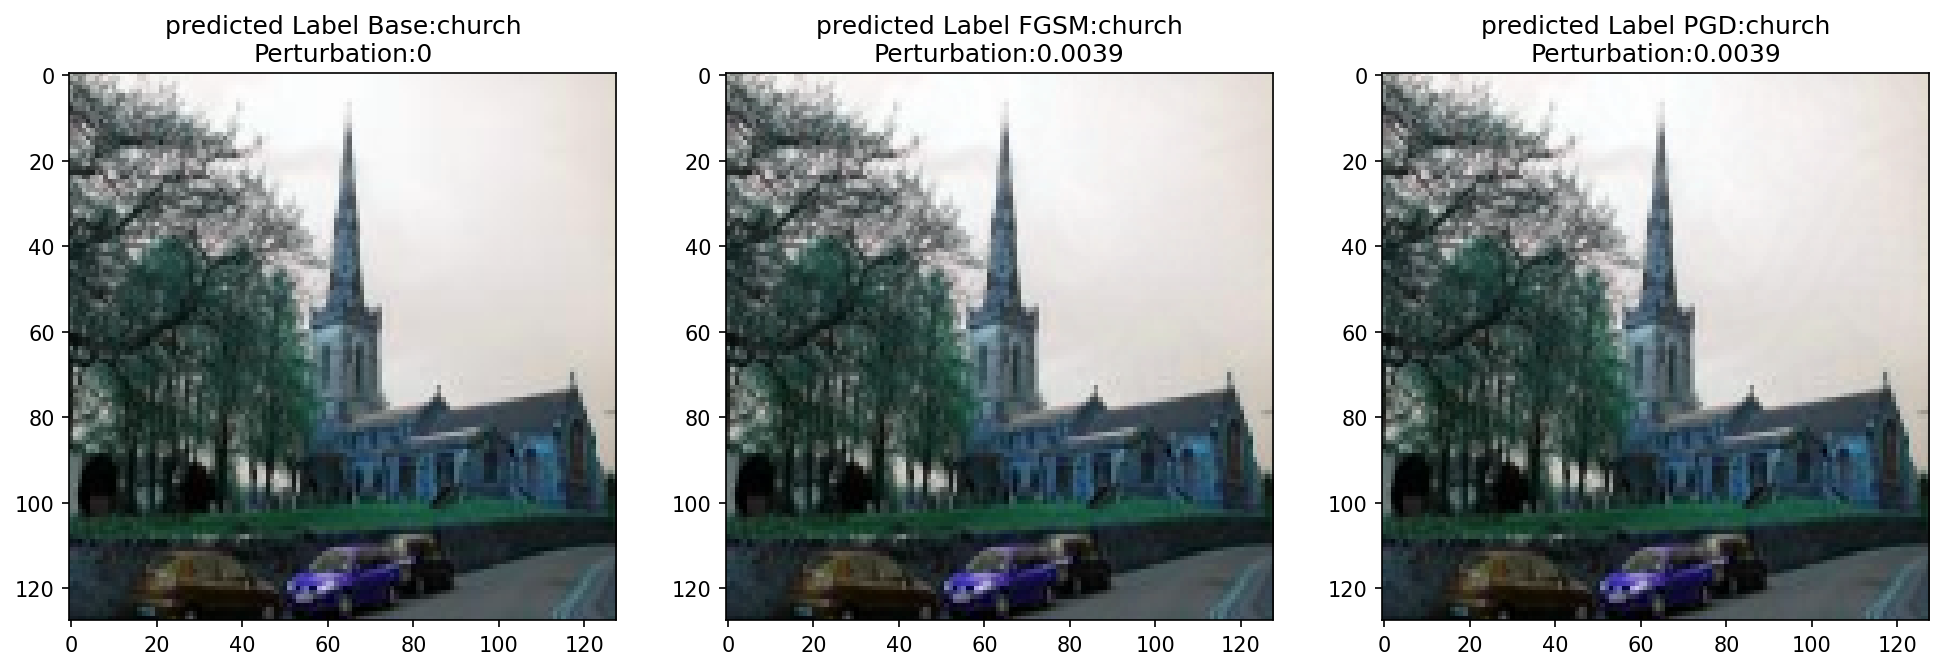

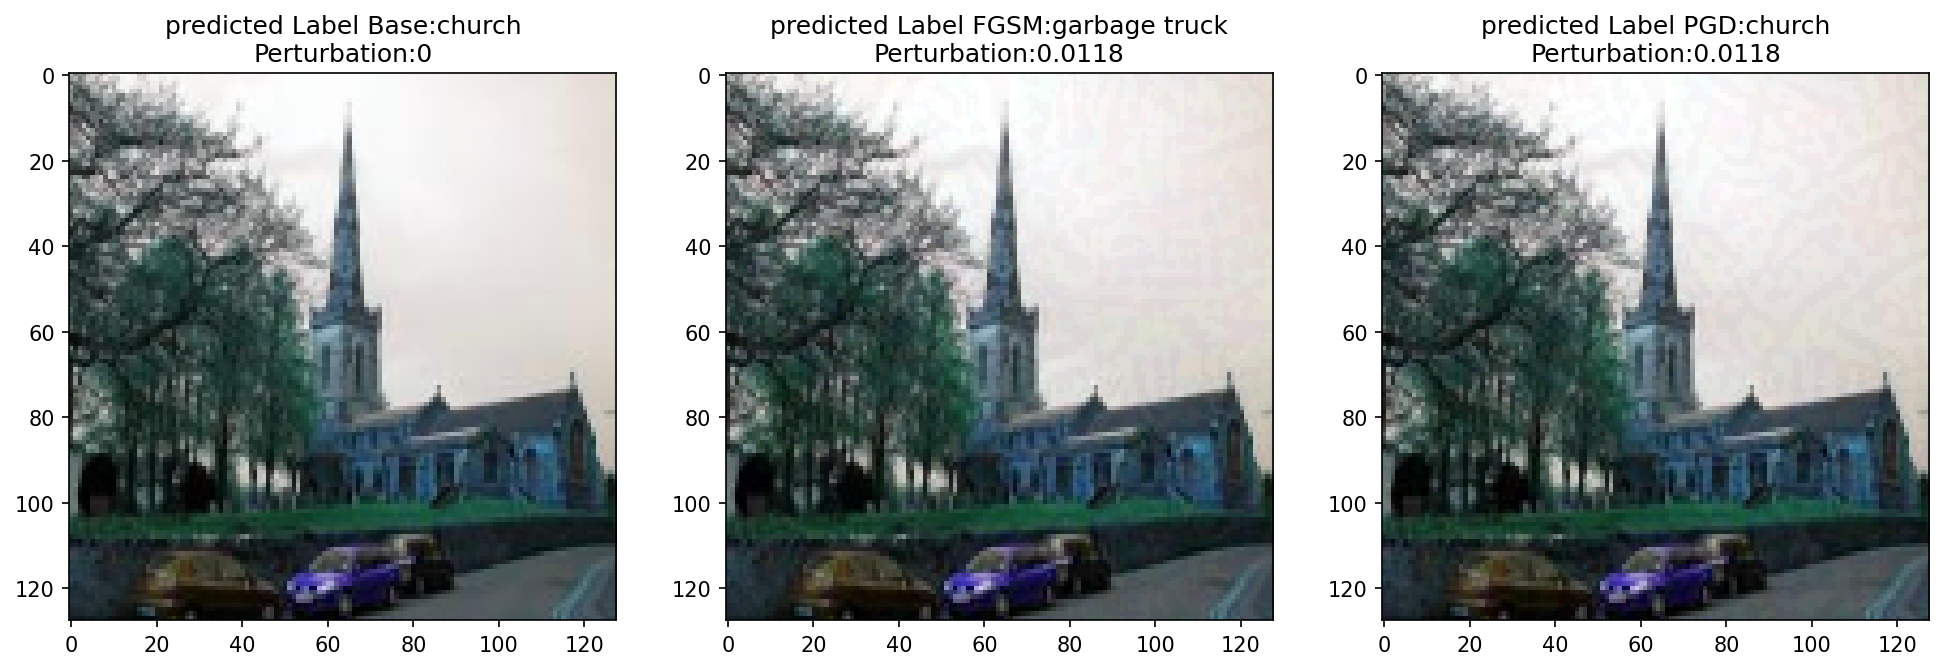

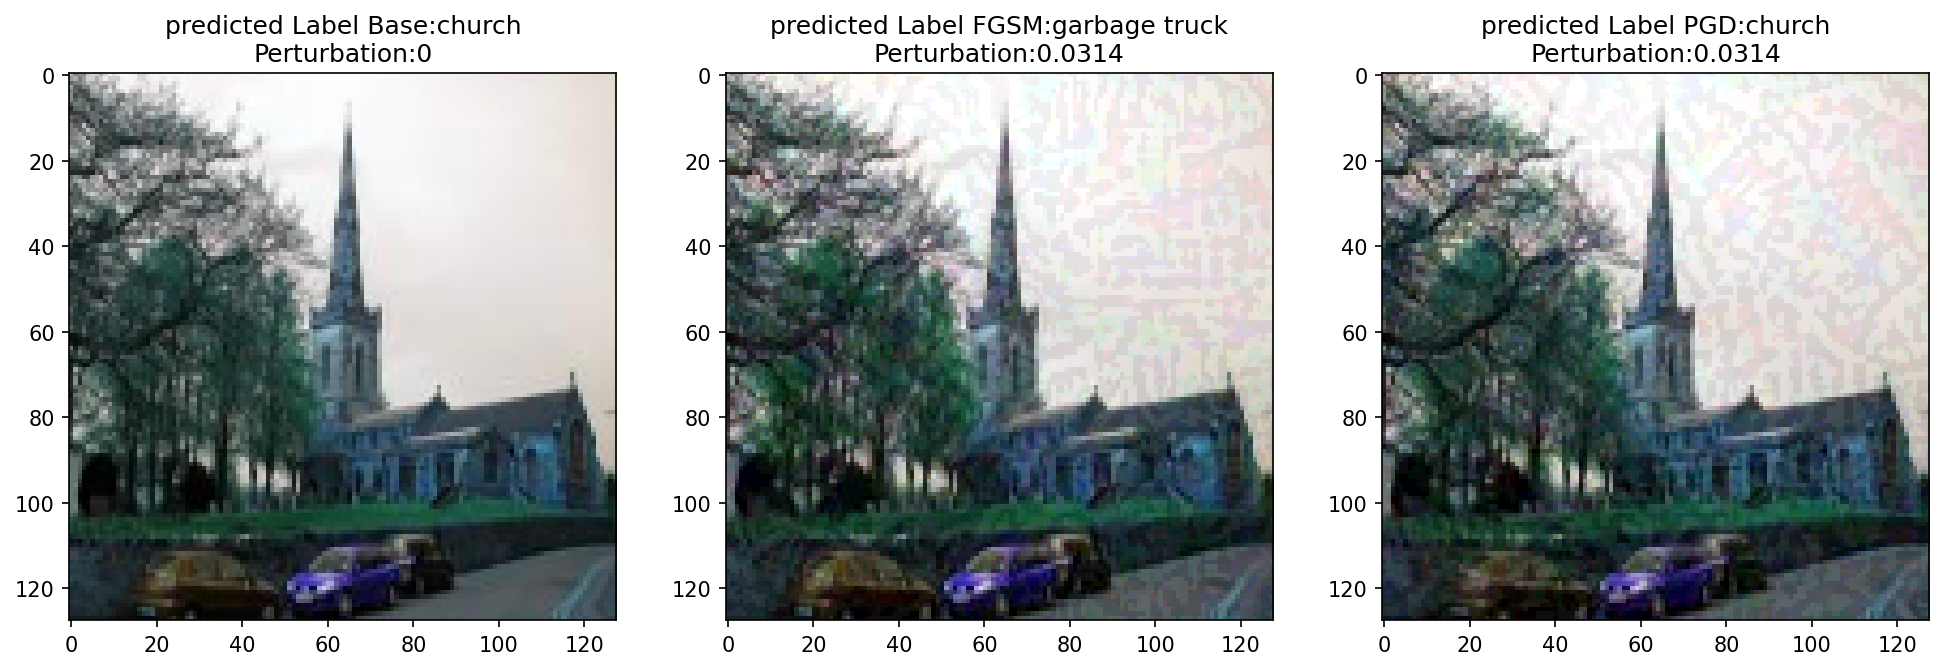

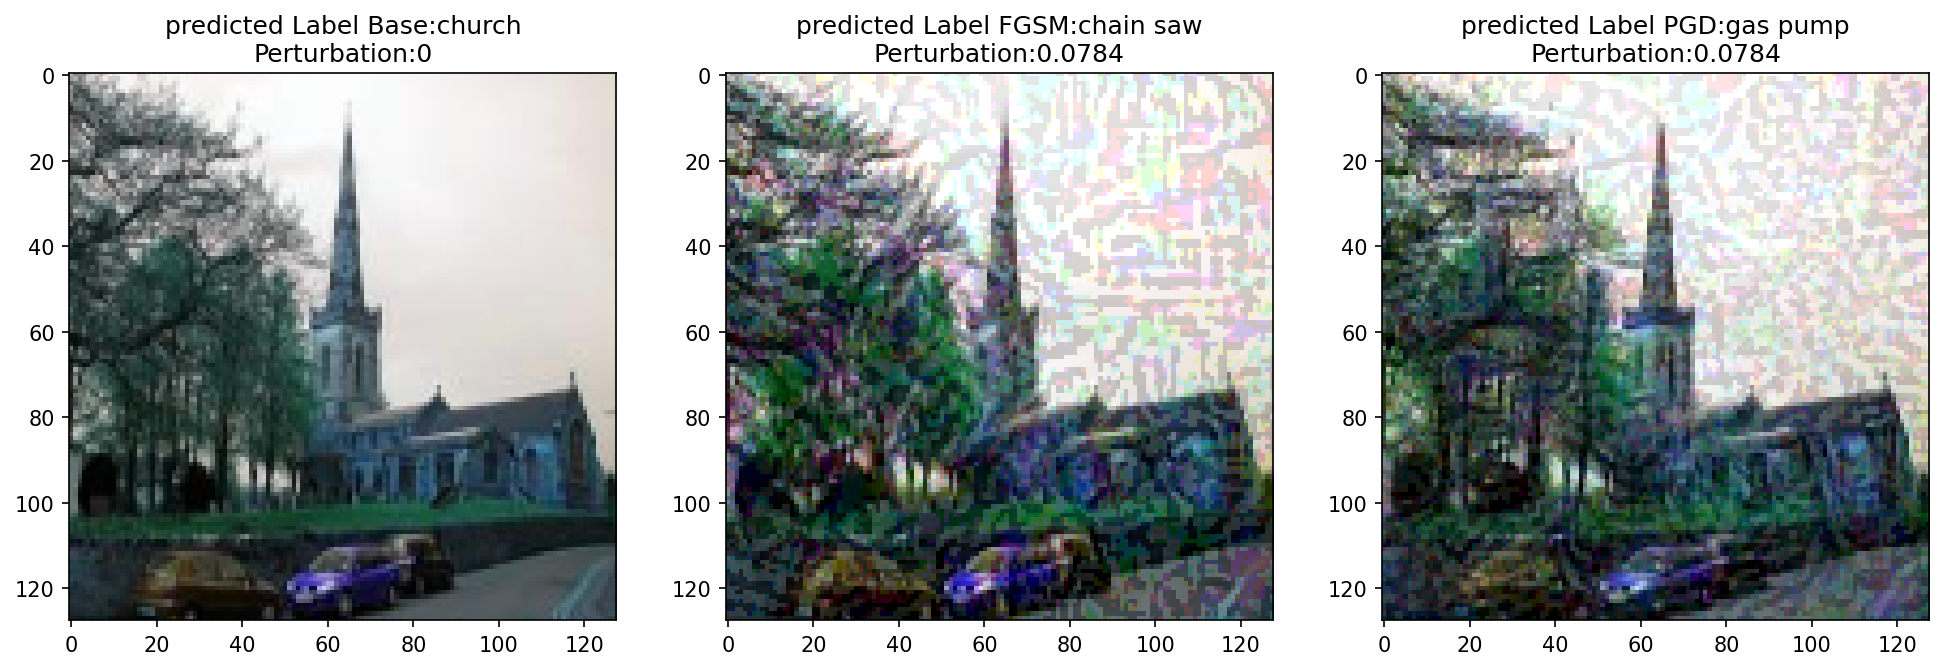

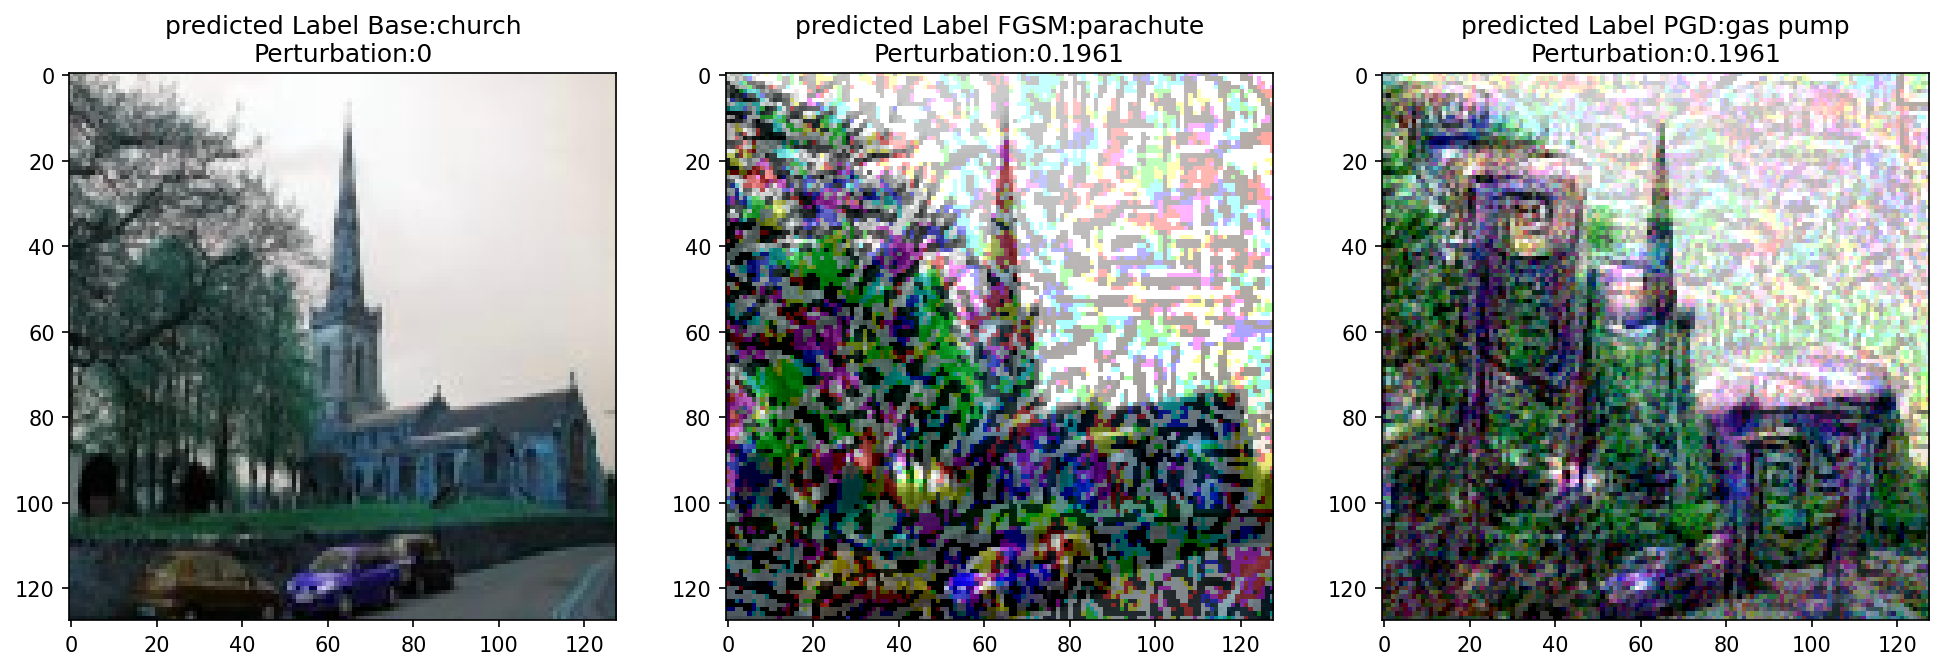

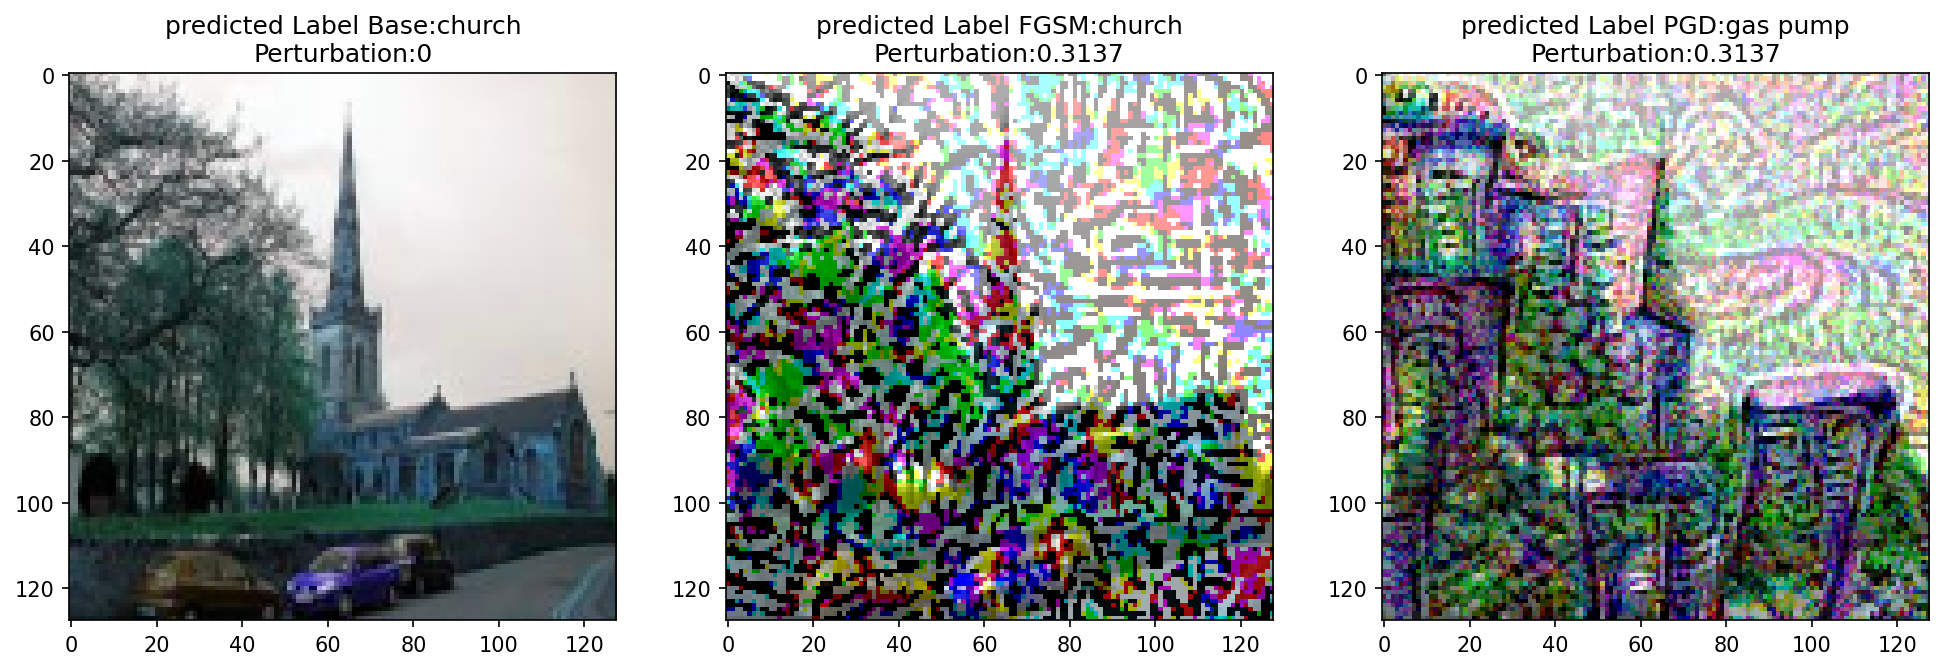

In [ ]:
def show_images(EpsilonIndex, AT):
    plt.figure(figsize=(16, 16), dpi=150)
    
    plt.subplot(1,3,1)
    plt.title('predicted Label Base:' + str(label_dict[np.argmax(AT.labels_church_cat[0])])+ '\n' + 'Perturbation:' + str(0))
    plt.imshow(AT.imgs_church[0])

    plt.subplot(1,3,2)
    plt.title('predicted Label FGSM:' + str(label_dict[int(AT.fgsm_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(AT.epsilon_list[EpsilonIndex],4)))
    plt.imshow(AT.fgsm_image_whole_list[EpsilonIndex][0])

    plt.subplot(1,3,3)
    plt.title('predicted Label PGD:' + str(label_dict[int(AT.pgd_pred_list[EpsilonIndex])])+ '\n' + 'Perturbation:' + str(round(AT.epsilon_list[EpsilonIndex],4)))
    plt.imshow(AT.pgd_image_whole_list[EpsilonIndex][0])
    fig_filename = "task3_b" + str(EpsilonIndex) + ".png"
    #plt.figure(frameon=False)
    fig_path = os.path.join("/content/drive/MyDrive/Colab_Notebooks/CS504/assg#1/figure/", fig_filename)
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

    plt.show()

def show_all_images(AT):
    new_epsilon = [1/255, 3/255, 8/255, 20/255, 50/255, 80/255]
    for item in new_epsilon:
        if item in AT.epsilon_list:
            index = AT.epsilon_list.index(item)
            show_images(index, AT)

show_all_images(at3)

## Task 3 report

### a) Classification accuracy table
| Perturbation Level | FGSM attack – <br>church label | FGSM attack –<br>gas pump label | PGD attack –<br>church label | PGD attack –<br>gas pump label | 
| :---: | :---: | :---: | :---: | :---: |
| **$\epsilon = 1/255$** | $94.31\%$ | $1.22\%$ | $96.75\%$ | $0.41\%$ |
| **$\epsilon = 3/255$** | $65.45\%$ | $11.79\%$  | $92.28\%$ | $4.47\%$ |
| **$\epsilon = 8/255$** | $29.67\%$ | $25.20\%$  | $91.87\%$ | $1.22\%$ |
| **$\epsilon = 20/255$** | $29.67\%$ | $12.20\%$  | $5.69\%$ | $92.68\%$ |
| **$\epsilon = 50/255$** | $70.33\%$ | $0.00\%$  | $17.07\%$ | $77.24\%$ |
| **$\epsilon = 80/255$** | $84.96\%$ | $0.00\%$  | $2.03\%$ | $97.15\%$ |

#### Discussion
Best $\epsilon$ for **FGSM** is $\epsilon = 8/255$, with accuracy on targeted label of $25.20\%$.

Best $\epsilon$ for **PGD** is $\epsilon = 20/255$, with accuracy on targeted label of $92.68\%$.

The **FGSM** model has a lower peak performance of accuracy at $25.20\%$, and started decreasing as $\epsilon$ grows. And the accuracy rate for the targeted label reached $0$ at $\epsilon = 50/255$.

While the **PGD** model outperformed the **FGSM** model with accuracies of $92.68\%$ and $97.15\%$, since the $\epsilon = 80/255$ will result in prominent weird images, I picked the one with lower $\epsilon = 20/255$ with slightly low accuracy as the best performance. Between the $\epsilon = 8/255$ and $\epsilon = 20/255$, the accuracy rate is boosted for the targeted labels. But after that, the accuracy decreased and returned to the peak at $97.15\%$.

According to the table, we can see that the attack accuracy is not linear correlative with the growth of $\epsilon$. Therefore, experiments are necessary to get the best $\epsilon$.


### b) Original and adversarial images
![task3_b0](./figure/task3_b0.png)

![task3_b1](./figure/task3_b1.png)

![task3_b3](./figure/task3_b3.png)

![task3_b4](./figure/task3_b4.png)

![task3_b5](./figure/task3_b5.png)

![task3_b6](./figure/task3_b6.png)

**Figure 3.** Original and adversarial images.